## New MOD

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.filters import sobel
from scipy.ndimage import label
from scipy.ndimage.morphology import binary_closing
from skimage.filters import threshold_otsu
from scipy.ndimage.filters import gaussian_filter

C:\Users\acer\AppData\Local\Temp\ipykernel_13924\4093736298.py:7: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_closing
C:\Users\acer\AppData\Local\Temp\ipykernel_13924\4093736298.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
covid_path = 'C:\\Users\\acer\\OneDrive\\Desktop\\COVID.jpeg'
co= cv2.imread(covid_path, cv2.IMREAD_COLOR)
covid =cv2.cvtColor(co,cv2.COLOR_BGR2GRAY)

norm_path = 'C:\\Users\\acer\\OneDrive\\Desktop\\NORM.jpeg'
nm= cv2.imread(norm_path, cv2.IMREAD_COLOR)
norm =cv2.cvtColor(nm,cv2.COLOR_BGR2GRAY)

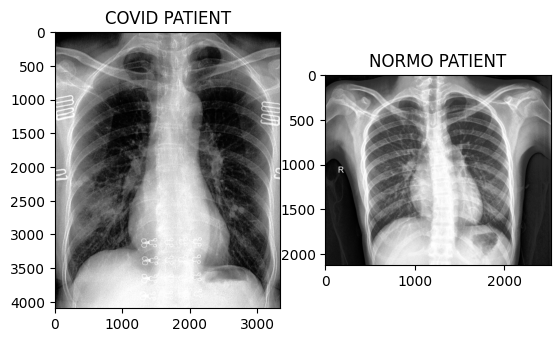

In [3]:
plt.figure()
plt.subplot(1,2,1)
plt.title("COVID PATIENT")
plt.imshow(covid, cmap='gray')

plt.subplot(1,2,2)
plt.title("NORMO PATIENT")
plt.imshow(norm, cmap='gray')

In [4]:
def downscale(image):
    # Downscale the image using interpolation
    downscaled_img = cv2.resize(image, (227,227), interpolation=cv2.INTER_AREA)

    # Convert the single-channel image to a three-channel image by replicating the channel
    downscaled_img = cv2.merge([downscaled_img] * 3)
    return downscaled_img


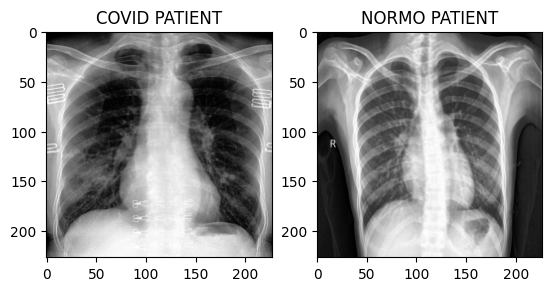

In [5]:
downscaled_covid= downscale(covid)
downscaled_norm=downscale(norm)
plt.figure()
plt.subplot(1,2,1)
plt.title("COVID PATIENT")
plt.imshow(downscaled_covid, cmap='gray')

plt.subplot(1,2,2)
plt.title("NORMO PATIENT")
plt.imshow(downscaled_norm, cmap='gray')

### Extraction of the Edges and the region

In [6]:
def edge_extraction(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = sobel(gray_image)
    plt.imshow(edges, cmap='gray')
    return edges


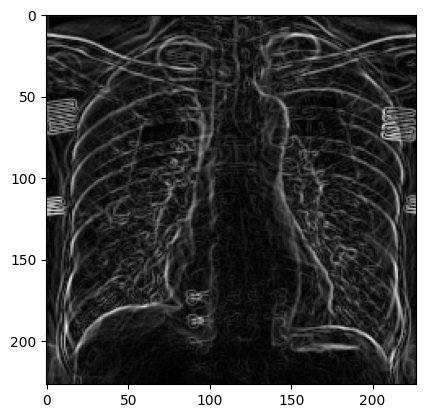

In [7]:
edged_img=edge_extraction(downscaled_covid)

In [8]:
def region_img(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thres = threshold_otsu(image)
    binary = image > thres
    binary_closed = binary_closing(binary, structure=np.ones((2,2)))
    labeled_image, num_features = label(binary_closed)
    feature_areas = np.bincount(labeled_image.ravel())[1:]   
    print(feature_areas)

    plt.figure(figsize=(8,7))
    plt.gray()
    plt.subplot(221), plt.imshow(image), plt.axis('off'), plt.title('original')
    plt.subplot(222), plt.imshow(binary), plt.axis('off'), plt.title('binray')
    plt.subplot(223), plt.imshow(binary_closed), plt.axis('off'), plt.title('binray closed')
    plt.subplot(224), plt.imshow(labeled_image, cmap='inferno'), plt.axis('off'), plt.title('labelled')
    plt.show()

[25794     1    97     1     1     1     1     1     1     2     1     1
     1     1     1     2     2     2     1     1     1]


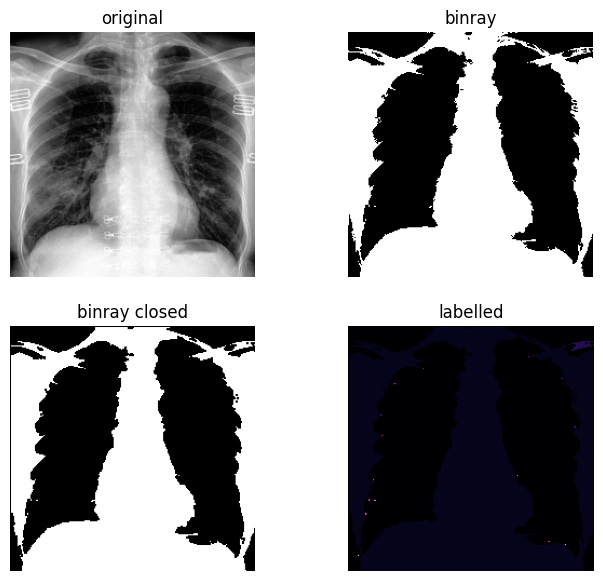

In [9]:
image_reg=region_img(downscaled_covid)

### Work on Patient with Morphological Filter

#### negative function

In [10]:
def negative(image):
    neg_image=np.zeros_like(image)
    for i in range(neg_image.shape[0]):
        for j in range(neg_image.shape[1]):
            neg_image[i,j]=255-image[i,j]
    return neg_image

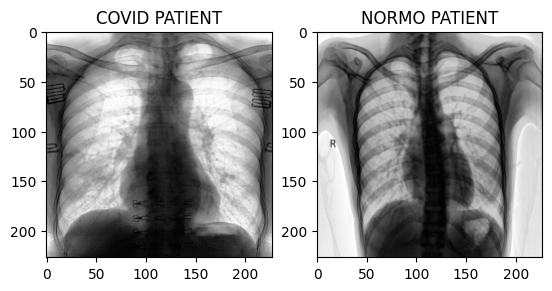

In [11]:
neg_covid=negative(downscaled_covid)
neg_norm=negative(downscaled_norm)
plt.figure()
plt.subplot(1,2,1)
plt.title("COVID PATIENT")
plt.imshow(neg_covid, cmap='gray')

plt.subplot(1,2,2)
plt.title("NORMO PATIENT")
plt.imshow(neg_norm, cmap='gray')

#### dilation x laplacian filter function

In [12]:
def laplacian_dilation(image):
    b,g,r=cv2.split(image)
    Laplacian= np.array([[-1, 0, -1], [0, 4, 0], [-1, 0, -1]])
    dil_matrix=np.zeros_like(b)
    kernel=np.ones((3,3), np.uint8)
    dilation=cv2.dilate(b,kernel, iterations=1)
    for i in range(1, dil_matrix.shape[0]-1, 3):
        for j in range(1, dil_matrix.shape[1]-1, 3):
            dil_matrix[i-1:i+2,j-1:j+2]= dilation[i-1:i+2,j-1:j+2]*Laplacian
    return dil_matrix

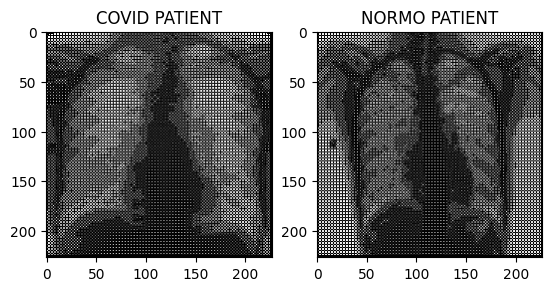

In [13]:
dilated_covid=laplacian_dilation(downscaled_covid)
dilated_norm=laplacian_dilation(downscaled_norm)
plt.figure()
plt.subplot(1,2,1)
plt.title("COVID PATIENT")
plt.imshow(dilated_covid, cmap='gray')

plt.subplot(1,2,2)
plt.title("NORMO PATIENT")
plt.imshow(dilated_norm, cmap='gray')

### edge extraction dilation - erosion

In [14]:
def diler(image):
    kernel=np.ones((7,7), np.uint8)
    dilation=cv2.dilate(image,kernel, iterations=5)
    erosion=cv2.erode(image,kernel, iterations=5)
    diler_matrix=dilation-erosion
    return diler_matrix

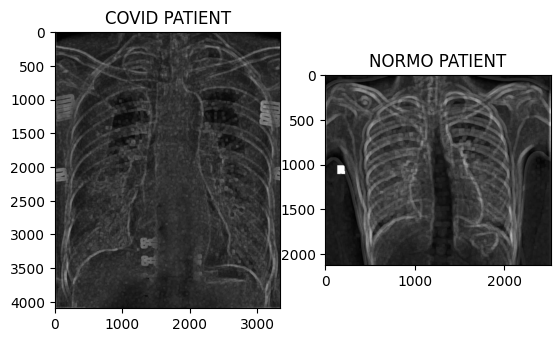

In [15]:
diler_covid=diler(covid)
diler_norm=diler(norm)
plt.figure()
plt.subplot(1,2,1)
plt.title("COVID PATIENT")
plt.imshow(diler_covid, cmap='gray')

plt.subplot(1,2,2)
plt.title("NORMO PATIENT")
plt.imshow(diler_norm, cmap='gray')


### black and white plus diler

In [16]:
def black_and_white(image):
    b,g,r=cv2.split(image)
    bw_matrix=b
    for i in range(bw_matrix.shape[0]):
        for j in range(bw_matrix.shape[1]):
            if bw_matrix[i,j]> 80:
                bw_matrix[i,j]=255
            else:
                bw_matrix[i,j]=0
    return bw_matrix

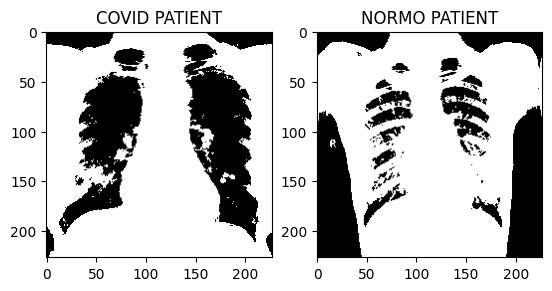

In [17]:
covid_bw= black_and_white(downscaled_covid)
norm_bw=black_and_white(downscaled_norm)
plt.figure()
plt.subplot(1,2,1)
plt.title("COVID PATIENT")
plt.imshow(covid_bw, cmap='gray')

plt.subplot(1,2,2)
plt.title("NORMO PATIENT")
plt.imshow(norm_bw, cmap='gray')

#### edge extraction in black and white

In [18]:
def black_and_white_2(image):
    bw_matrix=image
    for i in range(bw_matrix.shape[0]):
        for j in range(bw_matrix.shape[1]):
            if bw_matrix[i,j]> 80:
                bw_matrix[i,j]=255
            else:
                bw_matrix[i,j]=0
    return bw_matrix

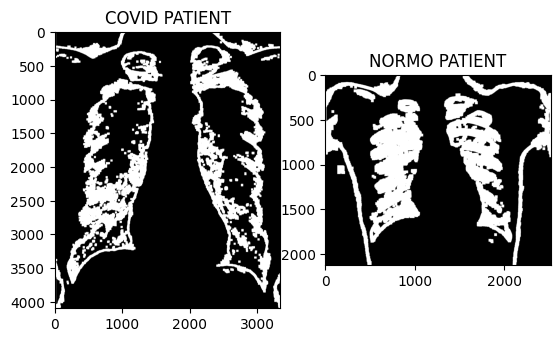

In [19]:
bw_covid_diler=diler(black_and_white_2(covid))
bw_norm_diler=diler(black_and_white_2(norm))
plt.figure()
plt.subplot(1,2,1)
plt.title("COVID PATIENT")
plt.imshow(bw_covid_diler, cmap='gray')

plt.subplot(1,2,2)
plt.title("NORMO PATIENT")
plt.imshow(bw_norm_diler, cmap='gray')

### Application of fourier

In [9]:
def fourier(image):
    b,g,r=cv2.split(image)
    im_f = np.fft.fft2(b)
    final_fourier = np.fft.fftshift(im_f)
    return final_fourier
    

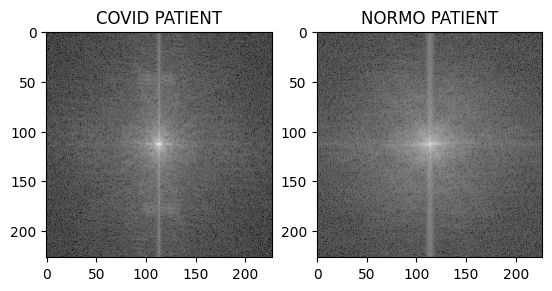

In [10]:
covid_f=fourier(downscaled_covid)
norm_f=fourier(downscaled_norm)
plt.figure()
plt.subplot(1,2,1)
plt.title("COVID PATIENT")
#plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(covid_f)), cmap='gray')


plt.subplot(1,2,2)
plt.title("NORMO PATIENT")
#plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(norm_f)), cmap='gray')

### HIGH PASS FILTER and INVERSION

In [7]:
def inverse_f(image):
    ishift_img = np.fft.ifftshift(image)
    ifft_img = np.fft.ifft2(ishift_img)
    abs_img = np.abs(ifft_img)
    return abs_img

In [8]:
def square_filter(fourier_image):
    fourier_matrix=fourier_image
    raw,col = fourier_matrix.shape
    half_raw, half_col = int(raw/2), int(col/2)
    n=25
    fourier_matrix[half_raw-n:half_raw+n+1,half_col-n:half_col+n+1] = 0
    plt.imshow(np.log(abs(fourier_matrix)), cmap='gray')
    return fourier_matrix
covid_sqr=square_filter(covid_f)

NameError: name 'covid_f' is not defined

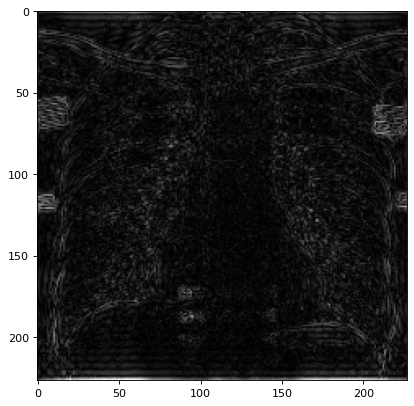

In [129]:
orig_ima=inverse_f(covid_sqr)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(orig_ima, cmap='gray')

high pass gaussian filter

In [79]:
def high_pass_gauss(image):
    fourier_img=fourier(image)
    # High-pass Gaussian filter parameters
    cutoff_frequency = 0.5 # Adjust this value based on your requirements
    sigma = 1 / (2 * np.pi* cutoff_frequency)
    filtered= gaussian_filter(fourier_img, sigma=0.48)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.log(abs(filtered)))
    gauss_img=inverse_f(filtered)
    plt.subplot(1,2,2)
    #plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(gauss_img, cmap='gray')

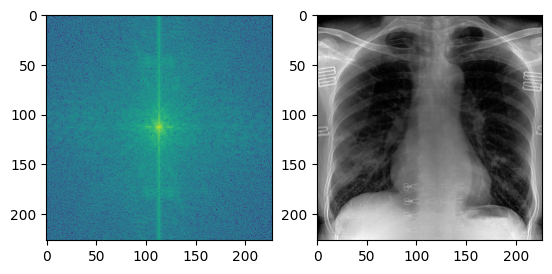

In [80]:
gauss_img=high_pass_gauss(downscaled_covid)